In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 8
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
d = pd.read_csv("v1298tau/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(4)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(4)]
p_init = [8.2438, 12.3960, 24.1315, 24.1315*2]

#%%
print (np.min(d.tc), np.max(d.tc))

2231.283312 4689.396172


In [3]:
errorobs[0] = jnp.ones_like(errorobs[0])*0.01
errorobs[1] = jnp.ones_like(errorobs[1])*0.005

In [4]:
dt = 0.2 * 2
t_start, t_end = 2230., 4700.
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.4000 (1/20 of innermost period)


initial objective function: 212195662.88 (46 data)

running LM optimization...
objective function: 87.43 (46 data)
# elapsed time (least square): 20.4 sec


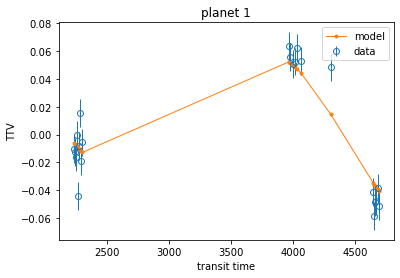

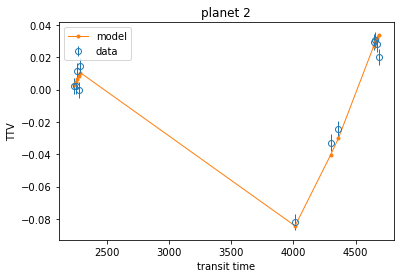

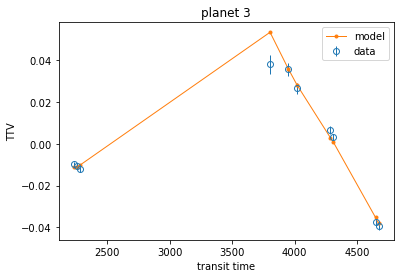

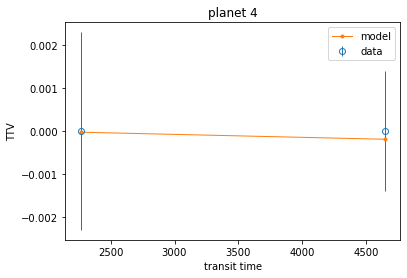

In [6]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.15)#, save=base+"ql")

In [7]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=4.00e-01): 2.92e-09
# fractional energy error (Hermite, dt=8.24e-03): -1.32e-11
# max difference in tc: 3.20e-05 days (2.77 sec)


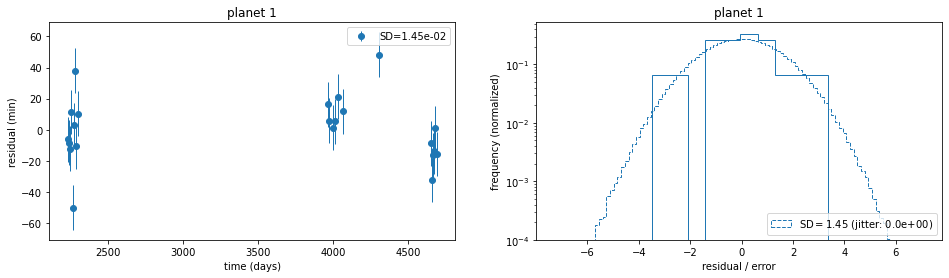

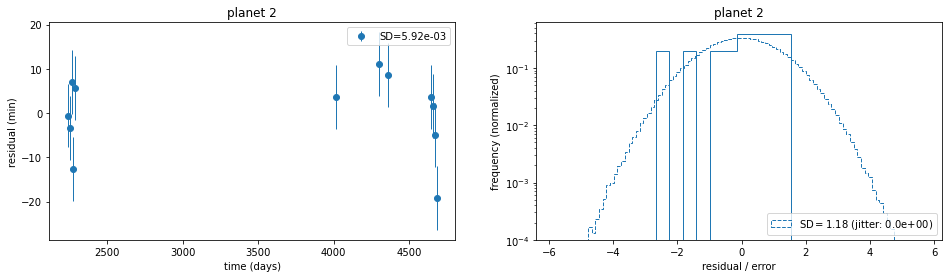

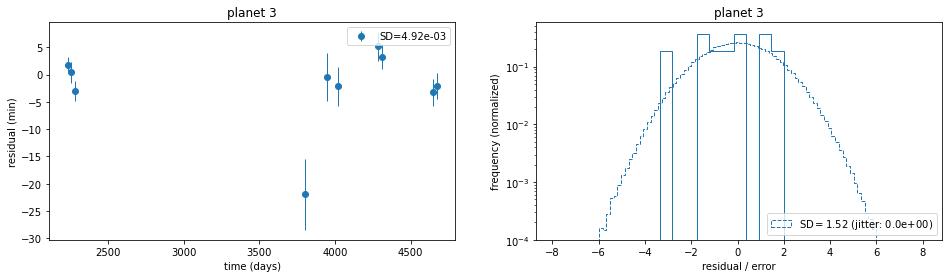

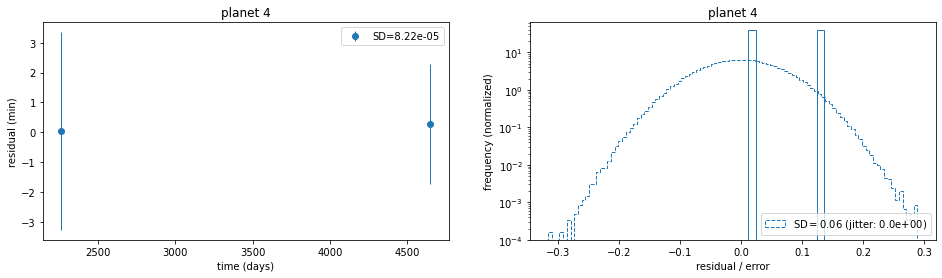

In [8]:
jttv.check_residuals(tc)

In [9]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  0.110017   8.248024  0.103884  0.087716  -0.0   -0.0  2231.287576   
1  0.105827  12.403792 -0.048837 -0.071056  -0.0   -0.0  2239.392515   
2  0.748275  24.140444 -0.065193  0.028381  -0.0    0.0  2234.048250   
3  1.542158  48.677002  0.067478 -0.149487   0.0    0.0  2263.623101   

        ecc     omega     lnmass          mass      cosw      sinw  
0  0.135963  0.701214 -14.922855  3.304354e-07  0.764060  0.645146  
1  0.086221 -2.172950 -14.961686  3.178500e-07 -0.566419 -0.824118  
2  0.071103  2.731003 -13.005720  2.247437e-06 -0.916885  0.399150  
3  0.164011 -1.146781 -12.282553  4.631854e-06  0.411423 -0.911444  


In [10]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

30.1 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None, nox=True):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    #elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)
    
    def bound(x, s=20, depth=30): 
        return -depth / (jnp.exp(-s * (x-0.5))+1)
    
    sma = numpyro.deterministic("sma", (period/365.25)**(2./3.))
    cnum = numpyro.deterministic("cnum", jnp.sum(jnp.where(sma[:-1] * (1 + ecc[:-1]) > sma[1:] * (1. - ecc[1:]), 1., 0.)))
    if nox:
        factor = bound(cnum)
        numpyro.factor("cross", factor)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [12]:
pdic_init

{'period': DeviceArray([ 8.24905019, 12.40170607, 24.13937799, 48.67723871], dtype=float64),
 'cosi': DeviceArray([-0.,  0., -0.,  0.], dtype=float64),
 'lnode': DeviceArray([-0., -0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([2231.28261532, 2239.39515618, 2234.04955446, 2263.62275226],            dtype=float64),
 'ecc': DeviceArray([0.07010396, 0.05592561, 0.07252002, 0.15682451], dtype=float64),
 'lnmass': DeviceArray([-11.72630613, -11.48233537, -15.45774416, -12.74766831], dtype=float64),
 'mass': DeviceArray([8.07848559e-06, 1.03106278e-05, 1.93547252e-07,
              2.90909563e-06], dtype=float64),
 'cosw': DeviceArray([-0.41724395, -0.58963875,  0.14412008, -0.58951659], dtype=float64),
 'sinw': DeviceArray([ 0.90879452,  0.8076671 ,  0.98956021, -0.80775627], dtype=float64)}

In [14]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [15]:
nw, ns, linm, tcjitter = 100, 100, True, None  # 9hr
nw, ns, linm, tcjitter = 500, 500, True, None  # 100hr
nw, ns, linm, tcjitter = 500, 500, True, None  # dt=0.4, emax=0.2, 57hr
nw, ns, linm, tcjitter = 500, 500, True, None  # dt=0.4, emax=0.5, no orbit crossing, 53hr

In [16]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [48]:
#output = "v1298tau/e02_dt%.1f_"%jttv.dt # emax=0.2
output = "v1298tau/nox_dt%.1f_"%jttv.dt

In [49]:
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit_"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [50]:
output

'v1298tau/nox_dt0.4_nw500_ns500_c8_'

In [51]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)# emax=0.2
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

v1298tau/nox_dt0.4_nw500_ns500_c8_mcmc.pkl loaded.


In [52]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      0.26      0.82      0.34     -1.24      1.50     43.06      1.25
   cosw[1]     -0.24      0.90     -0.19     -1.77      1.12     27.34      1.40
   cosw[2]      0.23      0.97      0.20     -1.42      1.84     13.17      1.40
   cosw[3]      0.00      1.05      0.07     -1.58      1.74     21.94      1.23
    ecc[0]      0.04      0.05      0.02      0.00      0.11      5.76      2.21
    ecc[1]      0.02      0.03      0.01      0.00      0.04     16.63      1.78
    ecc[2]      0.02      0.02      0.01      0.00      0.05     27.84      1.31
    ecc[3]      0.04      0.05      0.02      0.00      0.09      8.76      1.98
   mass[0]      0.00      0.00      0.00      0.00      0.00     19.97      1.44
   mass[1]      0.00      0.00      0.00      0.00      0.00     20.99      1.43
   mass[2]      0.00      0.00      0.00      0.00      0.00     14.06      1.36
   mass[3]      0.00      0

In [53]:
samples = mcmc.get_samples()

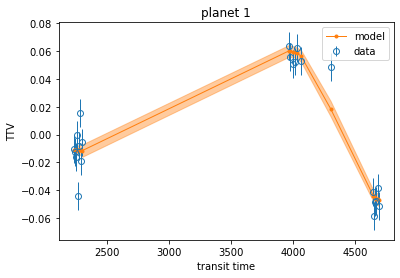

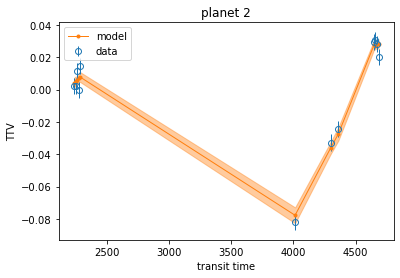

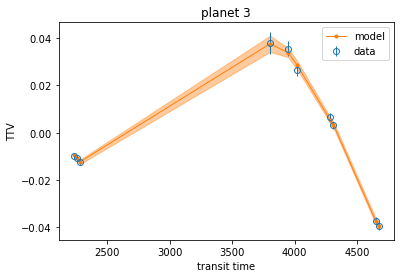

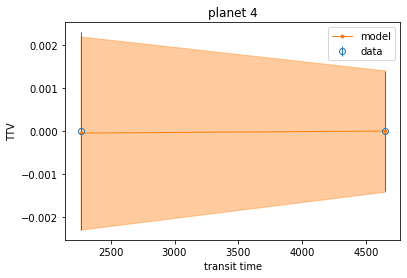

In [54]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=output+"postm")

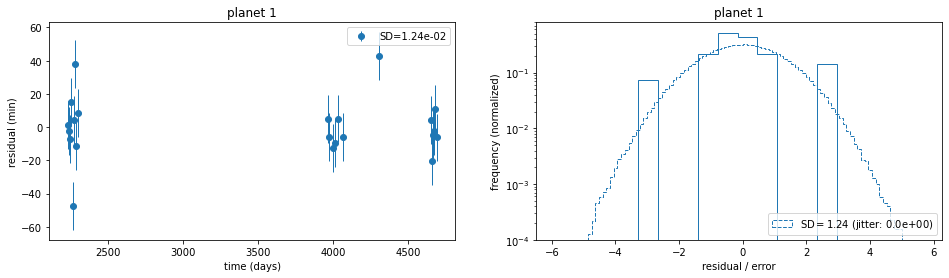

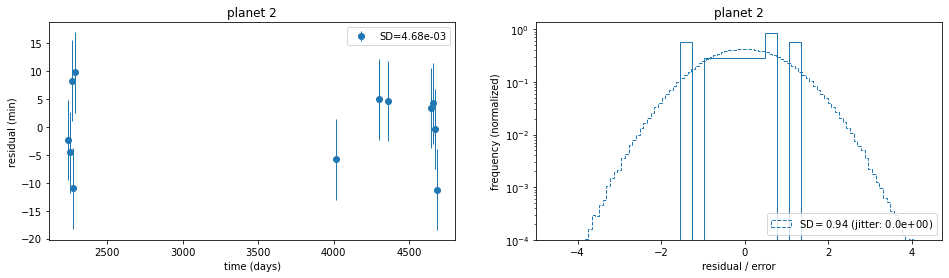

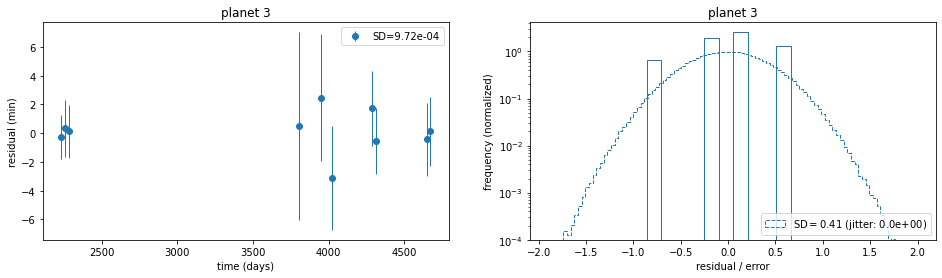

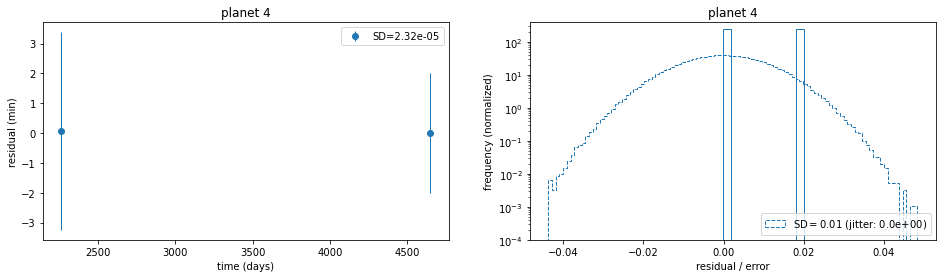

In [55]:
jttv.check_residuals(mmodel)

(array([   4.,   47.,   25.,   81.,  293.,  431.,  708., 1288.,  899.,
         224.]),
 array([-9.03555919, -8.81209815, -8.58863711, -8.36517607, -8.14171502,
        -7.91825398, -7.69479294, -7.4713319 , -7.24787086, -7.02440981,
        -6.80094877]),
 <BarContainer object of 10 artists>)

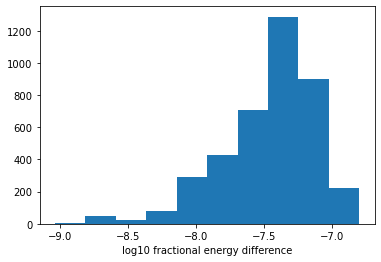

In [56]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [57]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

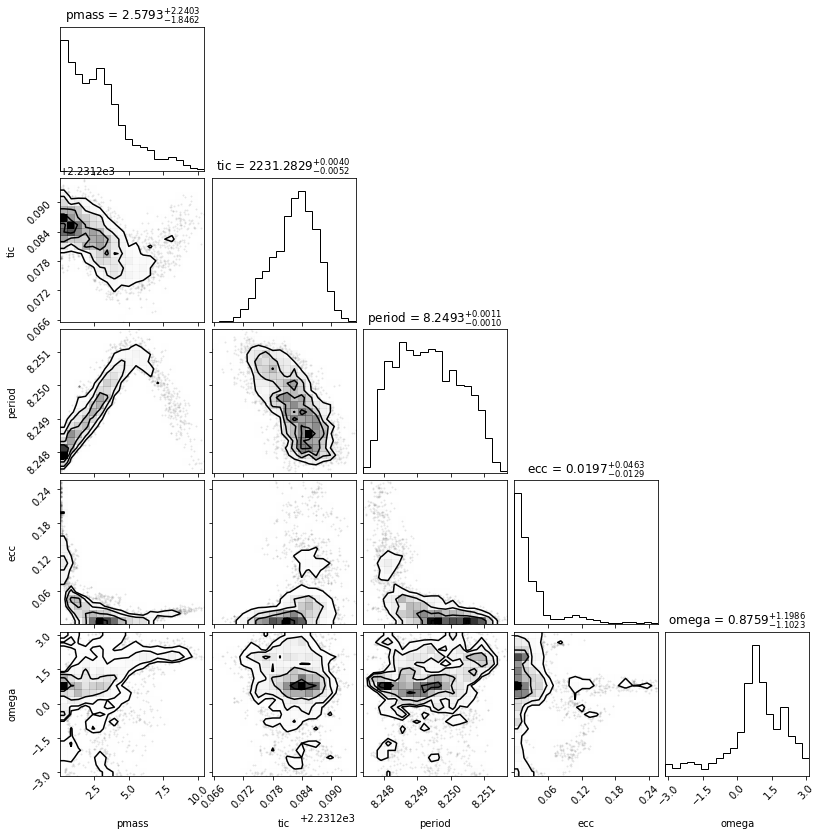

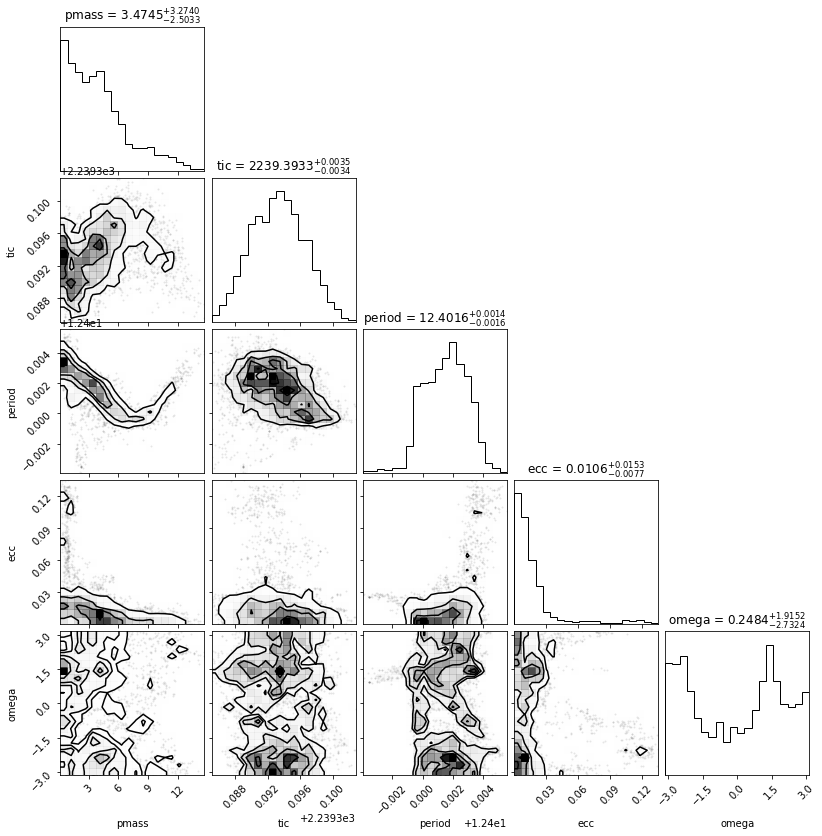

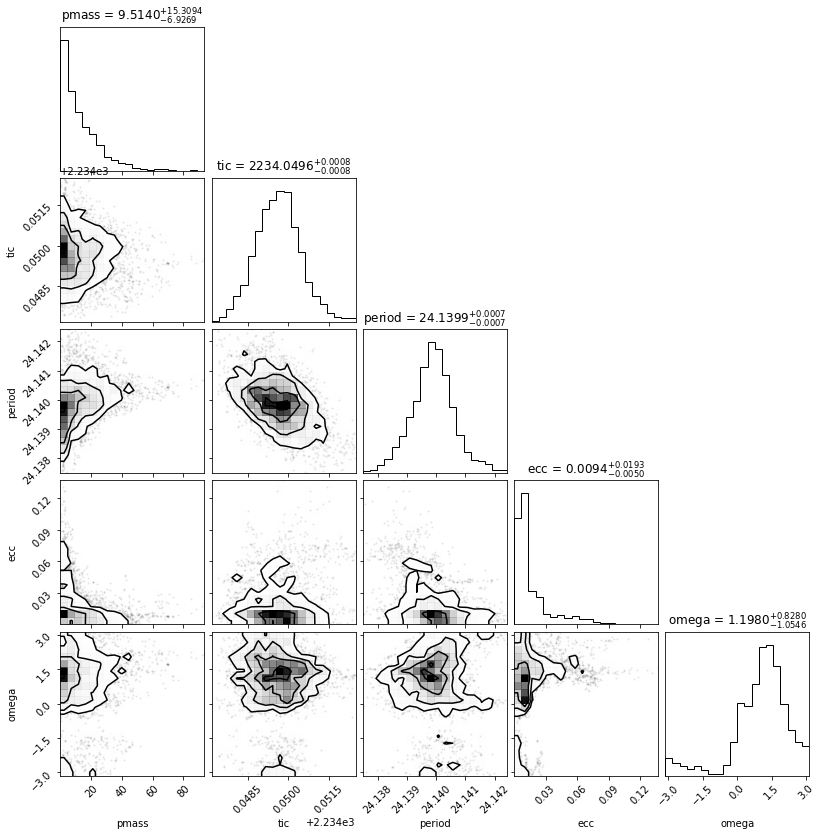

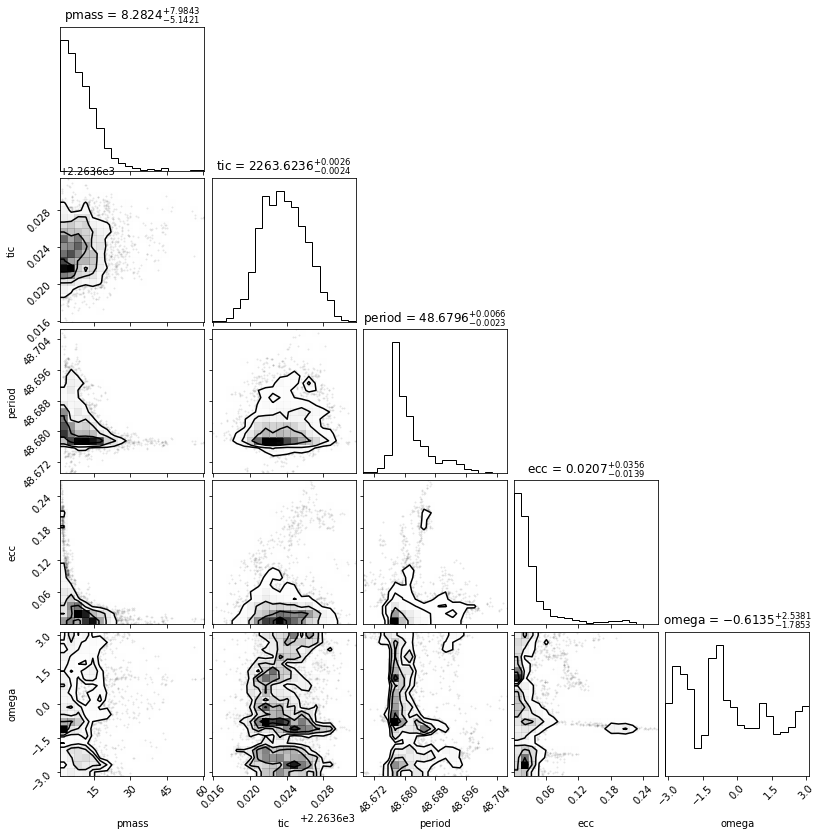

In [58]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f", bins=20)
    plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check convergence of transit times

In [59]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.0400 (1/206 of innermost period)


(array([ 7.,  1.,  5.,  0.,  0.,  0.,  0., 24.,  2.,  7.]),
 array([-19.34000233, -16.8918138 , -14.44362526, -11.99543673,
         -9.5472482 ,  -7.09905966,  -4.65087113,  -2.20268259,
          0.24550594,   2.69369447,   5.14188301]),
 <BarContainer object of 10 artists>)

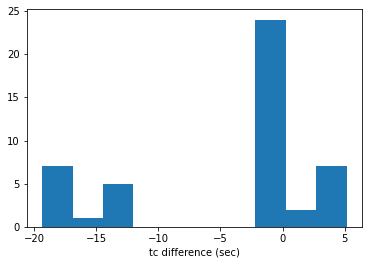

In [60]:
k = 10
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)